# Coding project - Picture enhancement

Write code that automatically enhances a photograph.

<img src="etretat.jpg" alt="view" width="300"/>
<img src= "ex_enhance.jpg" alt= "view" width= "300">

"Enhance" may mean a lot of different things, and we encourage you to be creative in which enhancements you want to implement.

Some possibilities include (not an exhaustive list):

* Noise reduction
* Auto-level
* Gamma correction (with gamma provided by the user or automatically determined from the image histogram)
* Increase colour saturation
* ...


-------------------------------------------------------------------------------------------------------------------------------------------
## Approach

In [35]:
# -- Your code here -- #
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave, imshow
from skimage.filters import median
from skimage.morphology import disk, opening, closing, rectangle
from skimage import img_as_float, img_as_ubyte
from skimage.color import rgb2hsv, hsv2rgb

By applying the morhpological operation, i'm just trying to discard the people on the image since they are litlle. (applied on each rgb channel separatly (for...)). since people are mor of a rectangular form, i used this morphological kernel insted of a classic disk

In [36]:
def morphological_closing(im, length=5, width= 2):
 
    selem = rectangle(length, width)
    # Allocate output array  of samesize
    out = np.zeros_like(im)
    
    # For each channel R, G, B, do an opening
    for c in range(3):
        out[..., c] = closing(im[..., c], selem)
        
    return out

As we have seen in this lab, i'll use a look up table to adjust the repartition of the histogram.

In [37]:
def build_autolevel_lut(im, low_pct=2, high_pct=98):
   
     
    hist, bins = np.histogram(im.flatten(), bins=256, range=(0, 255))
   
    #display the histogram
    plt.figure(figsize=(15,5))
    plt.plot(hist)
    plt.show()

    c_hist = np.cumsum(hist).astype(float)
    c_hist /= c_hist[-1]  # normalize to [0..1]

    # Function to find the intensity i where c_hist[i] crosses a given percentile
    def find_thresh(p):
        idx = np.where(c_hist >= p)[0]
        return idx[0] if len(idx) > 0 else 255
    
    
    Tmin = find_thresh(low_pct/100.0)
    Tmax = find_thresh(high_pct/100.0)

    
    lut = np.arange(256)
    
    lut[lut < Tmin] = 0
    
    lut[lut > Tmax] = 255
    # In between -> linear stretch
    mask = (lut >= Tmin) & (lut <= Tmax)
    lut[mask] = 255.0 * (lut[mask] - Tmin) / (Tmax - Tmin + 1e-5)  # +1e-5 to avoid /0
    # Convert to integer
    lut = lut.astype(np.uint8)
    return lut

def apply_lut(im, lut):
   
    return lut[im]



here in gamma transformation, we are just exponanciating every value of pixels in the image.

In [38]:
def apply_gamma(im, gamma):
   
    float_im = img_as_float(im)
    corrected = float_im ** gamma
    return corrected

here i turned the image into a HSV image, and i'm multiplying the saturation value by a factor (that i can choose). then i recompose the image to a rgb one.

In [39]:
def adjust_saturation(im, sat_factor):
    float_im = img_as_float(im)
    hsv = rgb2hsv(float_im)
    hsv[..., 1] *= sat_factor   # scale the saturation channel
    hsv[..., 1] = np.clip(hsv[..., 1], 0, 1)
    return hsv2rgb(hsv)

here, as in the lab, we are applying a median filter to the image. so we can remove the noise from it. here the example image isn't quite good because there are few noise. (we treat each channel separatly since the image is in 3D). 

at the end i decided to not use this function. 

In [40]:
def reduce_noise(im, radius=3):
    
    out = np.zeros_like(im)

    if len(im.shape) == 3 and im.shape[2] == 3:
        for c in range(3):
            out[..., c] = median(im[..., c], disk(radius))
    else:
        out = median(im, disk(radius))
    return out


# FINAL RESULT 

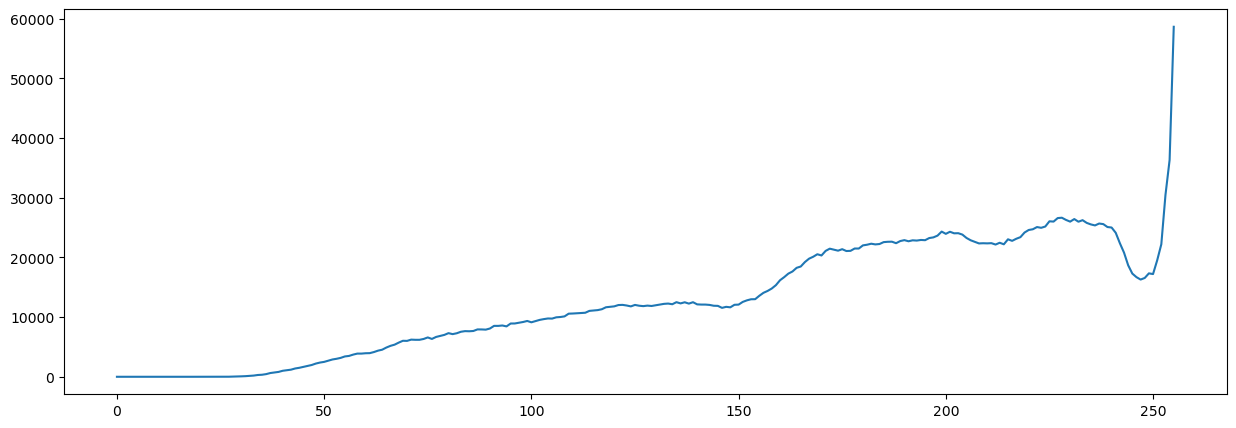

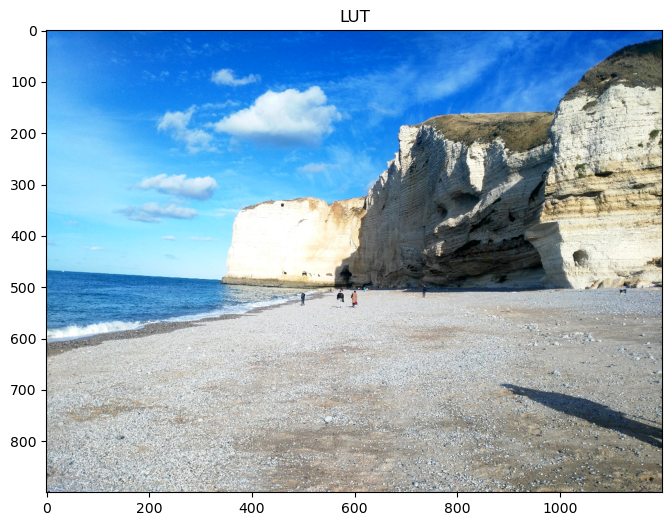

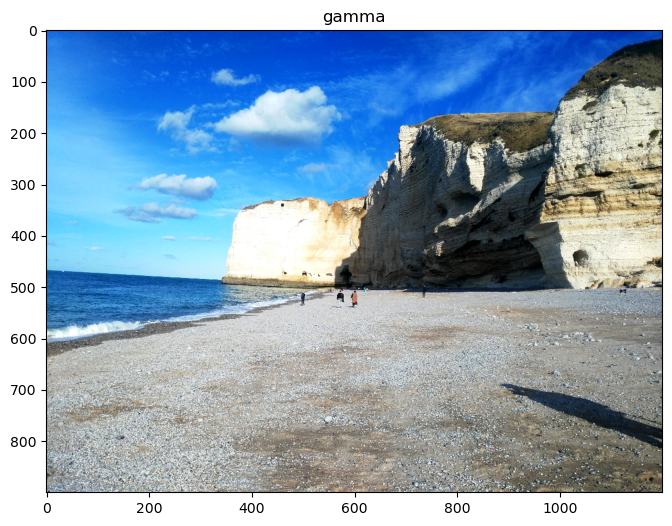

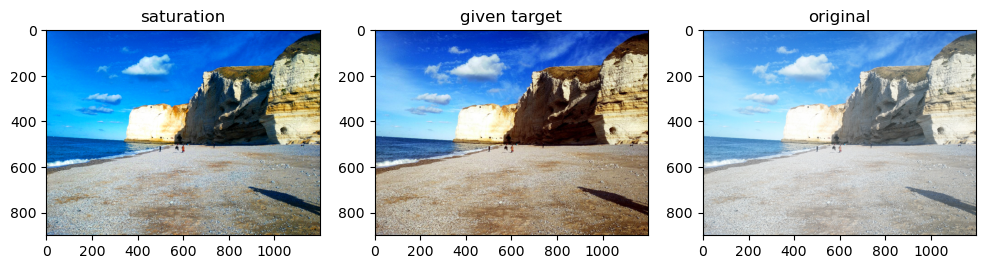

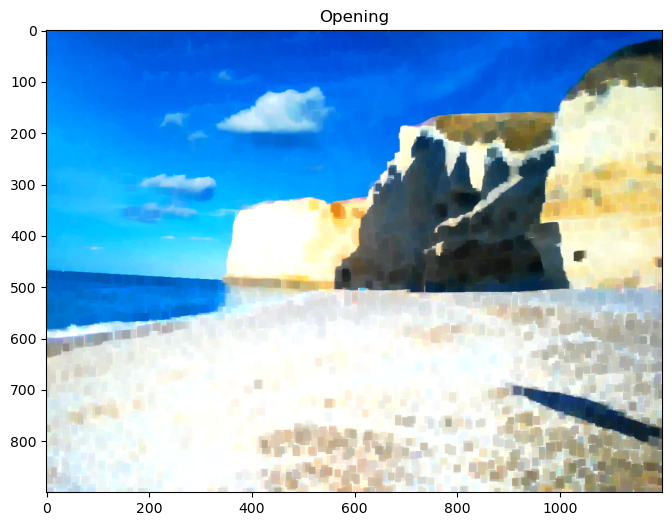

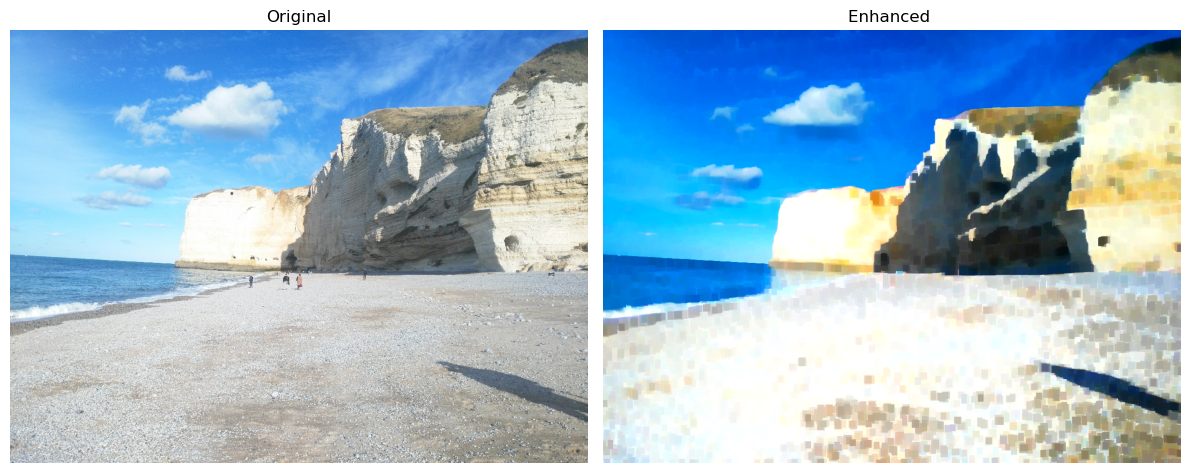

In [68]:

im_original = imread("etretat.jpg")
im_target= imread("ex_enhance.jpg")
# Ensure it's uint8
#if im_original.dtype != np.uint8:
    # For certain file types it may load as float, so rescale:
    #im_original = img_as_ubyte(im_original)


# 1) Noise reduction using morphological median
# im_denoised = reduce_noise(im_original, radius=2)
# plt.figure(figsize=(12,6))
# plt.title("Denoised")
# plt.imshow(im_denoised)

# 2) Build LUT for auto-level
lut_autolevel = build_autolevel_lut(im_original, low_pct=1, high_pct=95)


# 3) Apply the LUT
im_enhanced = apply_lut(im_original, lut_autolevel)
plt.figure(figsize=(12,6))
plt.title("LUT")
plt.imshow(im_enhanced)


# 4) gamma correction
im_enhanced = apply_gamma(im_enhanced, gamma=1.3)
plt.figure(figsize=(12,6))
plt.title("gamma")
plt.imshow(im_enhanced)

# 5) Adjust saturation
im_enhanced = adjust_saturation(im_enhanced, sat_factor=1.9)
imsave("final_enhance.jpg", img_as_ubyte(im_enhanced))
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title("saturation")
plt.imshow(im_enhanced)

plt.subplot(1,3,2)
plt.title("given target")
plt.imshow(im_target)

plt.subplot(1,3,3)
plt.title("original")
plt.imshow(im_original)


plt.show()


# 6) Morphological opening just to make the persons disappear
im_enhanced = morphological_closing(im_enhanced, length=14, width=11)
plt.figure(figsize=(12,6))
plt.title("Opening")
plt.imshow(im_enhanced)

# Display results
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(im_original, cmap='gray')
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Enhanced ")
plt.imshow(im_enhanced, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()


# Conclusion  

i'm quite satisfied about the image i produce. the filter worked not so well because there are few noise on the image. but the other functions worked well.

## LUT

i used the following purcentil : 1 and 95 because the image was very bright at first. 

## Gamma

i used a gamma of 1.3. when going <1, the image became much brighter. 